<a href="https://colab.research.google.com/github/doo3y/ML_Assignment_Final/blob/main/task_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 3: : Investigate the learnt CNN features from the last convolution layer and one intermediate layer.

<p>Machine Learning Assignment
<p>Duy Tran
<p>19313551
<p>17.05.2022

In [ ]:
!pip install -U d2l

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
from d2l import torch as d2l

In [ ]:
#ref: https://pytorch.org/vision/stable/models.html
transform = transforms.Compose(
        [transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 10

#validation and training set
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

#download 10000 testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

#split 50k dataset into train and validation
#ref: https://stackoverflow.com/questions/50544730/how-do-i-split-a-custom-dataset-into-training-and-test-datasets
train_size = int(0.7 * len(full_dataset))
validation_size = len(full_dataset) - train_size
train_dataset, validation_dataset = torch.utils.data.random_split(full_dataset, [train_size, validation_size])

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#load test dataset
test_iter = torch.utils.data.DataLoader(test_dataset, batch_size=128, 
                                        shuffle=True, num_workers=4)

In [ ]:
# initialise models and adjust final layer to correct number of classes
# ref: https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def initialize_model(model_name, num_classes=10, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = torchvision.models.resnet18(pretrained=use_pretrained)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        nn.init.xavier_uniform_(model_ft.fc.weight);

    return model_ft

In [ ]:
# ref: https://d2l.ai/chapter_computer-vision/fine-tuning.html
# If `param_group=True`, the model parameters in the output layer will be
# updated using a learning rate ten times greater
def train_fine_tuning(model_name, net, learning_rate, batch_size=128, num_epochs=10,
                      param_group=True):
    #load training dataset
    train_iter = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)
    #load validation dataset
    val_iter = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)
    devices = d2l.try_all_gpus()
    loss = nn.CrossEntropyLoss()
    if param_group:
        if model_name=="resnet":
            params_1x = [param for name, param in net.named_parameters()
             if name not in ["pretrained.fc.weight", "pretrained.fc.bias"]]
            trainer = torch.optim.SGD([{'params': params_1x},
                                   {'params': net.pretrained.fc.parameters(),
                                    'lr': learning_rate * 10}],
                                lr=learning_rate, weight_decay=0.001)
        else:
            params_1x = [param for name, param in net.named_parameters()
                if name not in ["classifier.6.weight", "classifier.6.bias"]]
            trainer = torch.optim.SGD([{'params': params_1x},
                                    {'params': net.classifier[6].parameters(),
                                        'lr': learning_rate * 10}],
                                    lr=learning_rate, weight_decay=0.001)
    else:
        trainer = torch.optim.SGD(net.parameters(), lr=learning_rate,
                                  weight_decay=0.001)
    d2l.train_ch13(net, train_iter, val_iter, loss, trainer, num_epochs,
                   devices)

In [ ]:
# softmax
# ref : implementation from tutorial 7 answer by Harrison
# https://www.youtube.com/watch?v=NVcJhMtRErE&list=PLyd8fQKbk5ej_lNdyAKI5aS_4hm-FhrrF&index=8
class SoftmaxRegression(nn.Module):
  def __init__(self, input_dim, output_dim, *args, **kwargs):
    super(SoftmaxRegression, self).__init__()
    self.layer = nn.Linear(input_dim, output_dim)

  def forward(self, X, *args, **kwargs):
    return F.softmax(self.layer(X), dim=-1)

class NewModel(nn.Module):
  def __init__(self, pretrained_model, output_model, num_layers):
    super(NewModel, self).__init__()
    self.pretrained = pretrained_model
    self.flatten = nn.Flatten()
    self.output = output_model
    # get intermediate layer in model
    # ref : https://forums.fast.ai/t/pytorch-best-way-to-get-at-intermediate-layers-in-vgg-and-resnet/5707
    self.features = nn.Sequential(*list(self.pretrained.children())[:num_layers])
  
  def forward(self, x):
    features = self.flatten.forward(self.features(x))
    return self.output.forward(features)

### softmax regression on original input

loss 0.016, train acc 0.439, test acc 0.396
3259.7 examples/sec on [device(type='cuda', index=0)]


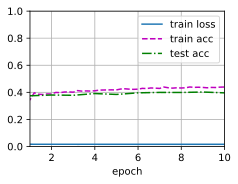

In [ ]:
softmax = SoftmaxRegression(150528, 10)
resnet = initialize_model('resnet')
net = NewModel(resnet, softmax, 0)
train_fine_tuning('resnet', net, 3e-3)

In [ ]:
#test dataset accuracy
d2l.evaluate_accuracy_gpu(net, test_iter)

0.4038

### softmax on last convolution layer

loss 0.012, train acc 0.965, test acc 0.911
637.4 examples/sec on [device(type='cuda', index=0)]


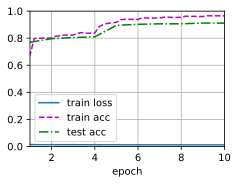

In [ ]:
softmax = SoftmaxRegression(25088, 10)
resnet = initialize_model('resnet')
net = NewModel(resnet, softmax, 8)
train_fine_tuning('resnet', net, 3e-3)

In [ ]:
#test dataset accuracy
d2l.evaluate_accuracy_gpu(net, test_iter)

0.9155

### softmax on an intermediate layer

loss 0.015, train acc 0.500, test acc 0.472
1946.1 examples/sec on [device(type='cuda', index=0)]


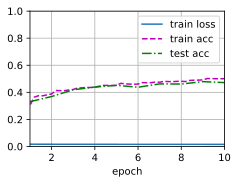

In [ ]:
softmax = SoftmaxRegression(200704, 10)
resnet = initialize_model('resnet')
net = NewModel(resnet, softmax, 4)
train_fine_tuning('resnet', net, 3e-3)

In [ ]:
#test dataset accuracy
d2l.evaluate_accuracy_gpu(net, test_iter)

0.4724